# Sunspots Data Predict

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset

import pytorch_lightning as pl
from pytorch_lightning.metrics import functional as FM

from GetData import SunspotData
from BaseModel import BaseModel

## Define Model

In [2]:
class Model(BaseModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rnn = nn.LSTM(1, 64, 2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ELU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, X):
        h0 = Variable(torch.zeros(2, X.size(0), 64)).cuda()
        c0 = Variable(torch.zeros(2, X.size(0), 64)).cuda()
        X, (hn, cn) = self.rnn(X, (h0, c0))
        return self.fc(X[:, -1, :])
    
    def test_epoch_end(self, outputs):
        h, y = zip(*outputs)
        h = torch.flatten(torch.cat(h, 0)).cpu().numpy()
        y = torch.flatten(torch.cat(y, 0)).cpu().numpy()
        plt.scatter(y, h)
        plt.show()

## Train And Predict

In [6]:
data_module = SunspotData(1320, batch_size=128)
model = Model(F.mse_loss, metrics_fn=[(FM.mean_absolute_error, 'mae')])
trainer = pl.Trainer(gpus=1, max_epochs=100)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [7]:
trainer.fit(model, datamodule=data_module)


  | Name | Type       | Params
------------------------------------
0 | rnn  | LSTM       | 50.4 K
1 | fc   | Sequential | 2.1 K 
------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params


1

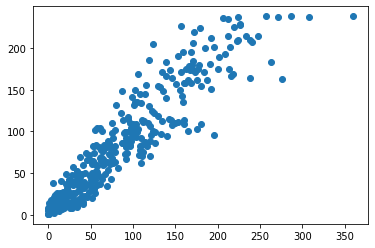


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss/test': tensor(599.5712, device='cuda:0'),
 'mae/test': tensor(16.9442, device='cuda:0')}
--------------------------------------------------------------------------------


[{'mae/test': 16.94416046142578, 'loss/test': 599.5712280273438}]

In [8]:
trainer.test(datamodule=data_module)